# Speech Emotion Recognition (CREMA Dataset)

## 0. Problem Statement

The main goal of this lab is to build a CNN model that detects human emotions from speech using the CREMA dataset, by turning speech clips into features that can help a computer recognize emotions like humans do.

## 1. Imports and Utilities

In [3]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display, HTML
from collections import defaultdict
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
# configurations
SEED = 42
SAMPLE_RATE = 22050 # number of audio samples captured per second
FRAME_LENGTH = 2048 # number of samples per analysis frame
HOP_LENGTH = 512    # samples between consecutive frame starts 
                    # instead of jumping the frame length we jump 512 so that the frames overlap to get smooth detailed analysis
DURATION = 3
TARGET_LENGTH = SAMPLE_RATE * DURATION
# compute the exact number of frames for 3s clips which will be (3*22050)/512 = 130
N_FRAMES = int(np.ceil(TARGET_LENGTH / HOP_LENGTH))
EMOTION_MAP = {
    'ANG': 'Angry', 'DIS': 'Disgust', 'FEA': 'Fear',
    'HAP': 'Happy', 'NEU': 'Neutral', 'SAD': 'Sad'
}

## 2. Dataset Loading and Visualizing

In [5]:

class DataLoader:
    def __init__(self,audio_dir="Crema/"):
        self.audio_dir = audio_dir
        self.file_groups = defaultdict(list)
        self.emotion_colors = {
            "ANG":"#d62728", "DIS":"#2ca02c","FEA":"#7f7f7f",
            "HAP":"#ff7f0e", "NEU":"#1f77b4","SAD":"#9467bd"
        }
        self.load_dataset()
        self.print_dataInfo_report()

    def load_dataset(self):
        n_files = 0
        for file_name in sorted(os.listdir(self.audio_dir)):
            if file_name.endswith('.wav'):
                parts = file_name.split("_")
                base_id = "_".join(parts[:2])
                emotion = parts[2]
                full_path = os.path.join(self.audio_dir,file_name)

                self.file_groups[base_id].append((emotion,full_path))
                n_files += 1
        print(f"Loaded {n_files} audio files")
        self.filter_groups()

    def filter_groups(self):
        self.file_groups = {k: v for k,v in self.file_groups.items() if len({item[0] for item in v}) > 1}

    def print_dataInfo_report(self):
        emotion_counts = defaultdict(int)
        for i in self.file_groups.values():
            for emotion, _ in i:
                emotion_counts[emotion] +=1

        display(HTML(
            f"<h2 style='color:#2c3e50; border-bottom: 3px solid #3498db;'>"
            "Dataset Info Report</h2>"
            f"<p style='font-size:16px;'>"
            f"Groups: {len(self.file_groups)}<br>"
            f"Emotion distribution:<br>"
            + "<br>".join([f" • {e}: {c} samples" for e,c in emotion_counts.items()]) +
            "</p>"
        ))

    def load_audio(self,path):
        signal,_ = librosa.load(path,sr=SAMPLE_RATE,duration=DURATION)
        return librosa.util.fix_length(signal,size=TARGET_LENGTH)
    
    def display_audio(self,signal,emotion):
        display(HTML(
            f"<div style='margin:10px 0; padding-left:8px; border-left: 3px solid {self.emotion_colors[emotion]}'>"
            f"<span style='color:{self.emotion_colors[emotion]}; font-weight:bold;'>{EMOTION_MAP[emotion]}</span> sample:"
            "</div>"
        ))
        display(Audio(data=signal,rate=SAMPLE_RATE))
    
    def plot_waveforms(self, n_groups=1):
        # plot all emotions with waveform for the same audio id
        groups = list(self.file_groups.keys())
        rng = np.random.default_rng(SEED)
        selected_groups = rng.choice(groups, size=min(n_groups, len(groups)), replace=False)

        for group_id in selected_groups:
            group_data = self.file_groups[group_id]
            emotions = [item[0] for item in group_data]
            
            # first pass load all signals and find global amplitude range
            signals = []
            global_max = 0
            for emotion, path in group_data:
                signal = self.load_audio(path)
                signals.append(signal)
                current_max = np.max(np.abs(signal))
                global_max = max(global_max, current_max)
            
            # 10% padding to amplitude range
            y_min = -global_max * 1.1
            y_max = global_max * 1.1
            
            # plots
            fig = plt.figure(figsize=(12, 3 * len(emotions)), dpi=100, 
                            constrained_layout=True)
            fig.suptitle(f"Emotion Waveforms: {group_id}", y=1.02, 
                        fontsize=16, fontweight='bold')
            
            for i, ((emotion, path), signal) in enumerate(zip(group_data, signals), 1):
                ax = fig.add_subplot(len(emotions), 1, i)
                time = np.linspace(0, DURATION, len(signal))
                
                ax.plot(time, signal, 
                        color=self.emotion_colors[emotion],
                        alpha=0.8,
                        linewidth=1.2)
                
                ax.set_title(f"{emotion} - {EMOTION_MAP[emotion]}",
                            color=self.emotion_colors[emotion],
                            fontsize=12,
                            pad=20,  
                            loc='left',
                            y=1.05,  
                            fontweight='bold')

                ax.set_ylim(y_min, y_max)
                ax.set_xlim(0, DURATION)
                ax.set_xlabel("Time (seconds)" if i == len(emotions) else "",
                            fontsize=10)
                ax.set_ylabel("Amplitude", fontsize=10)
                ax.tick_params(axis='both', labelsize=8)
                ax.grid(True, alpha=0.3)
                
                self.display_audio(signal, emotion)

            plt.show()

Loaded 7442 audio files


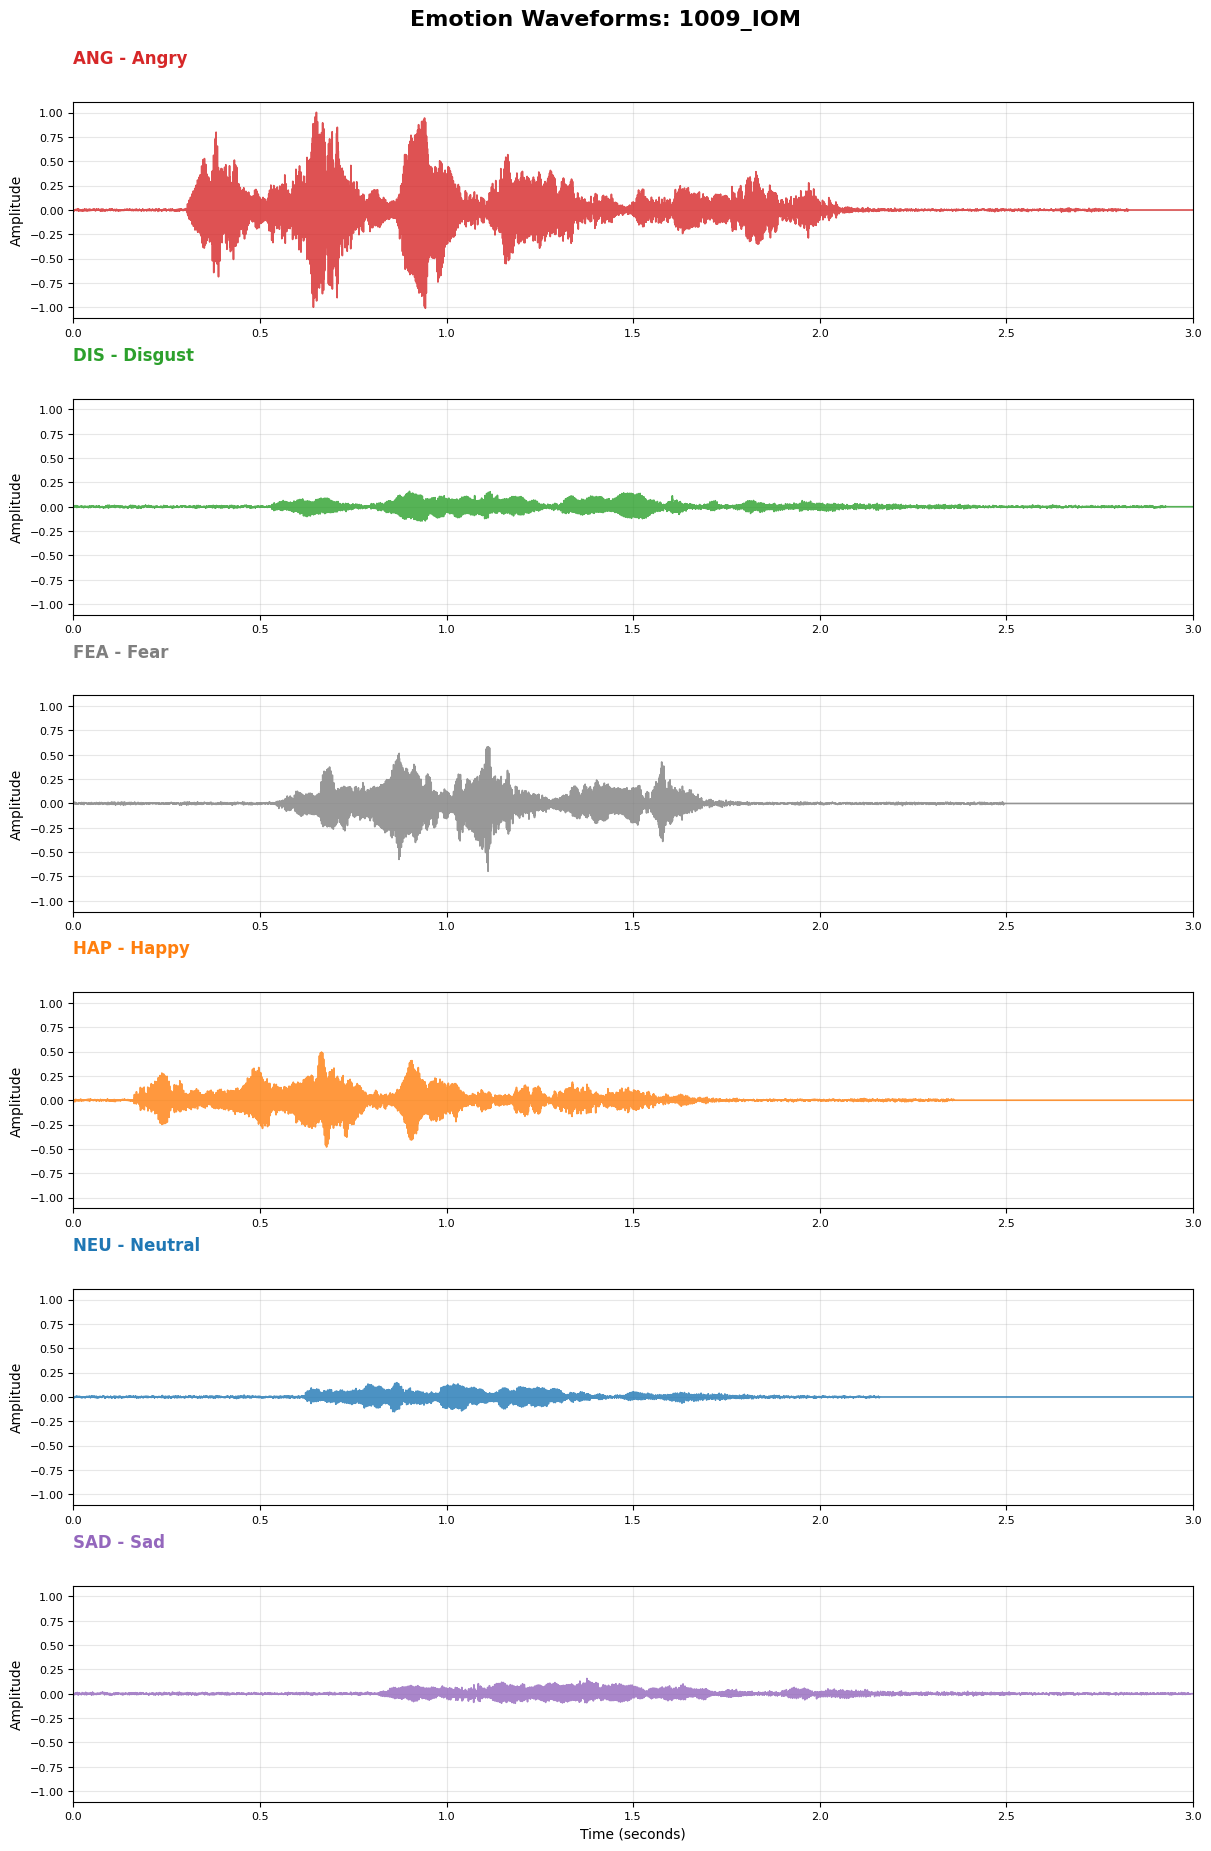

In [6]:
data_loader = DataLoader()
data_loader.plot_waveforms()

## 3. Create the Feature Space

In [7]:
class FeatureExtraction:
    def __init__(self):
        self.frame_length = FRAME_LENGTH
        self.hop_length = HOP_LENGTH
        self.n_frames = N_FRAMES

    def extract_time_features(self,signal):
        zero_cross_rate = librosa.feature.zero_crossing_rate(y=signal,frame_length=self.frame_length,hop_length=self.hop_length)[0]
        energy = librosa.feature.rms(y=signal,frame_length=self.frame_length,hop_length=self.hop_length)[0]
        # pad or truncate to the fixed length
        zero_cross_rate = np.pad(zero_cross_rate, (0, max(0, self.n_frames - len(zero_cross_rate))), mode='constant')[:self.n_frames]
        energy = np.pad(energy, (0, max(0, self.n_frames - len(energy))), mode='constant')[:self.n_frames]
        return np.stack([zero_cross_rate,energy],axis=1)
    
    def extract_mel_spectrogram(self,signal):
        mel_spec = librosa.feature.melspectrogram(y=signal,sr=SAMPLE_RATE,n_fft=self.frame_length,hop_length=self.hop_length,n_mels=128)
        mel_db = librosa.power_to_db(mel_spec,ref=np.max)
        resized = resize(mel_db,(128,128),anti_aliasing=True)
        return resized[..., np.newaxis]

## 4. Build Model

### 4.1 Data Split

In [8]:
class DataSplitter:
    @staticmethod
    def split(X_time, X_mel, y, test_size=0.3, val_size=0.05, random_state=SEED):
        indices = np.arange(len(y))
        # initial train test split
        train_val_idx, test_idx = train_test_split(
            indices, 
            test_size=test_size,
            stratify=y,
            random_state=random_state
        )

        # validation split
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=val_size/(1-test_size),
            stratify=y[train_val_idx],
            random_state=random_state
        )

        X_train_time, X_val_time, X_test_time = X_time[train_idx], X_time[val_idx], X_time[test_idx]
        X_train_mel, X_val_mel, X_test_mel = X_mel[train_idx], X_mel[val_idx], X_mel[test_idx]
        y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]
        
        return (X_train_time, X_val_time, X_test_time,
                X_train_mel, X_val_mel, X_test_mel,
                y_train, y_val, y_test)

In [9]:
# feature extraction
extractor = FeatureExtraction()
time_features = []
mel_features = []
labels = []

# collecting all data
for id, items in data_loader.file_groups.items():
    for emotion, path in items:
        signal = data_loader.load_audio(path)
        time_features.append(extractor.extract_time_features(signal))
        mel_features.append(extractor.extract_mel_spectrogram(signal))
        labels.append(emotion)

X_time = np.array(time_features)
X_mel = np.array(mel_features)

# encode labels
le = LabelEncoder().fit(labels)
y = le.transform(labels)

print("Data shapes:")
print("-" * 20)
print(f"Time features: {X_time.shape}")
print(f"Mel spectrograms: {X_mel.shape}")

Data shapes:
--------------------
Time features: (7442, 130, 2)
Mel spectrograms: (7442, 128, 128, 1)


In [10]:
# data splitting
splitter = DataSplitter()
(X_train_time, X_val_time, X_test_time,
 X_train_mel, X_val_mel, X_test_mel,
 y_train, y_val, y_test) = splitter.split(X_time, X_mel, y)

assert X_train_time.shape[1:] == (N_FRAMES, 2)
assert X_train_mel.shape[1:]  == (128, 128, 1)

print("Time features shapes:", X_train_time.shape, X_val_time.shape, X_test_time.shape)
print("Mel features shapes:", X_train_mel.shape, X_val_mel.shape, X_test_mel.shape)
print("Labels:", np.unique(y_train, return_counts=True))

Time features shapes: (4836, 130, 2) (373, 130, 2) (2233, 130, 2)
Mel features shapes: (4836, 128, 128, 1) (373, 128, 128, 1) (2233, 128, 128, 1)
Labels: (array([0, 1, 2, 3, 4, 5]), array([825, 826, 826, 826, 707, 826]))


### 4.2 CNN Model

In [ ]:
#inception v3 built in



from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

y_train_onehot = to_categorical(y_train, num_classes=6)
y_val_onehot = to_categorical(y_val, num_classes=6)
y_test_onehot = to_categorical(y_test, num_classes=6)

# Step 3: Create and compile the model
base_model = InceptionV3(weights=None, input_shape=(128, 128, 1), include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(
    X_train_mel, y_train_onehot,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_mel, y_val_onehot)
)

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_mel, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.3232 - loss: 1.9847 - val_accuracy: 0.1716 - val_loss: 2.5083
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.4317 - loss: 1.4371 - val_accuracy: 0.3861 - val_loss: 1.5216
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.4608 - loss: 1.3452 - val_accuracy: 0.1635 - val_loss: 3.5174
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.4955 - loss: 1.2975 - val_accuracy: 0.3378 - val_loss: 2.4192
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.4880 - loss: 1.3131 - val_accuracy: 0.3351 - val_loss: 2.5091
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5324 - loss: 1.1875 - val_accuracy: 0.4048 - val_loss: 1.5746
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5703 - loss: 1.1241 - val_accuracy: 0.4531 - val_loss: 1.3979
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.6227 - loss: 0.9918 - val_accu

In [ ]:
#inception resnet v2 built in



from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

y_train_onehot = to_categorical(y_train, num_classes=6)
y_val_onehot = to_categorical(y_val, num_classes=6)
y_test_onehot = to_categorical(y_test, num_classes=6)
base_model = InceptionResNetV2(weights=None, input_shape=(128, 128, 1), include_top=False)
# Step 3: Create and compile the model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the model
history = model.fit(
    X_train_mel, y_train_onehot,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_mel, y_val_onehot)
)

# Step 5: Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_mel, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 516s 3s/step - accuracy: 0.3716 - loss: 1.7760 - val_accuracy: 0.4075 - val_loss: 1.4957
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 429s 3s/step - accuracy: 0.4665 - loss: 1.3294 - val_accuracy: 0.2842 - val_loss: 2.1206
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.5434 - loss: 1.1867 - val_accuracy: 0.2520 - val_loss: 3.0028
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 397s 3s/step - accuracy: 0.5798 - loss: 1.0897 - val_accuracy: 0.2306 - val_loss: 3.5577
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.6160 - loss: 1.0064 - val_accuracy: 0.3700 - val_loss: 1.9410
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 414s 3s/step - accuracy: 0.6485 - loss: 0.9405 - val_accuracy: 0.3887 - val_loss: 2.3482
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.6661 - loss: 0.8784 - val_accuracy: 0.3164 - val_loss: 2.7776
Epoch 8/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 417s 3s/step - accuracy: 0.7099 - loss: 0.7599 - val_acc

In [ ]:
# first tensor flow base model

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical

def build_ser_cnn(input_shape=(128, 128, 1), num_classes=6):
    model = models.Sequential()

    # Explicit input layer (optional but clear)
    model.add(layers.InputLayer(input_shape=input_shape))

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Optional deeper block
    model.add(layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.GlobalAveragePooling2D())

    # Dense head
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
model = build_ser_cnn(input_shape=(128, 128, 1), num_classes=6)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',  # or 'categorical_crossentropy' for one-hot
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

y_train_onehot = to_categorical(y_train, num_classes=6)
y_val_onehot = to_categorical(y_val, num_classes=6)
y_test_onehot = to_categorical(y_test, num_classes=6)

history = model.fit(
    X_train_mel, y_train_onehot,  # Ensure y_train is provided
    validation_data=(X_val_mel, y_val_onehot),  # Ensure y_val is provided
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 504ms/step - accuracy: 0.3548 - loss: 1.6427 - val_accuracy: 0.1716 - val_loss: 17.0151 - learning_rate: 0.0010
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 513ms/step - accuracy: 0.3897 - loss: 1.5122 - val_accuracy: 0.1903 - val_loss: 4.6480 - learning_rate: 0.0010
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 515ms/step - accuracy: 0.4549 - loss: 1.3983 - val_accuracy: 0.3137 - val_loss: 4.8608 - learning_rate: 0.0010
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 79s 517ms/step - accuracy: 0.4672 - loss: 1.3916 - val_accuracy: 0.2869 - val_loss: 2.5666 - learning_rate: 0.0010
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 78s 514ms/step - accuracy: 0.4820 - loss: 1.3456 - val_accuracy: 0.3861 - val_loss: 1.6899 - learning_rate: 0.0010
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 77s 507ms/step - accuracy: 0.4975 - loss: 1.3158 - val_accuracy: 0.2172 - val_loss: 2.6499 - learning_rate: 0.0010
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 525ms/step - accuracy: 0.

In [28]:
test_loss, test_accuracy = model.evaluate(X_test_mel, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.5298 - loss: 1.2933
Test Loss: 1.3222664594650269
Test Accuracy: 0.521271824836731


In [ ]:
# 2nd tensor flow base model
import tensorflow as tf
from tensorflow.keras import layers, models

def build_ser_cnn(input_shape=(128, 128, 1), num_classes = 6):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    # Block 1: Stem
    model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'valid'))

    # Block 2_1
    model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'valid'))

    # Block 2_2
    model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'valid'))


    # Block 3_1
    model.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'valid'))

    # Block 3_2
    model.add(layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides = (2, 2), padding = 'valid'))

    # Dense head
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [65]:
model = build_ser_cnn(input_shape=(128, 128, 1), num_classes=6)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',  # or 'categorical_crossentropy' for one-hot
    metrics=['accuracy']
)

model.summary()
# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
]

# y_train_onehot = to_categorical(y_train, num_classes=6)
# y_val_onehot = to_categorical(y_val, num_classes=6)
# y_test_onehot = to_categorical(y_test, num_classes=6)

history = model.fit(
    X_train_mel, y_train,  # Ensure y_train is provided
    validation_data=(X_val_mel, y_val),  # Ensure y_val is provided
    epochs=20,
    callbacks=callbacks
)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_280 (Conv2D)             │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_280         │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_153 (ReLU)                │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 64, 64, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_281 (Conv2D)             │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_281         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_282 (Conv2D)             │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_282         │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_154 (ReLU)                │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_153               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_283 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_283         │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_284 (Conv2D)             │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_284         │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_155 (ReLU)                │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_154               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_285 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_285         │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_286 (Conv2D)             │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_286         │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 4,994,822 (19.05 MB)

 Trainable params: 4,990,854 (19.04 MB)

 Non-trainable params: 3,968 (15.50 KB)

Epoch 1/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.3450 - loss: 1.6756 - val_accuracy: 0.1716 - val_loss: 15.3710 - learning_rate: 0.0010
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.4235 - loss: 1.4175 - val_accuracy: 0.1930 - val_loss: 5.8901 - learning_rate: 0.0010
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.4561 - loss: 1.3651 - val_accuracy: 0.1769 - val_loss: 8.1021 - learning_rate: 0.0010
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.5009 - loss: 1.2919 - val_accuracy: 0.2279 - val_loss: 4.9032 - learning_rate: 0.0010
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.5026 - loss: 1.2388 - val_accuracy: 0.3271 - val_loss: 2.5826 - learning_rate: 0.0010
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.5218 - loss: 1.1915 - val_accuracy: 0.2198 - val_loss: 4.3425 - learning_rate: 0.0010
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.5469 - loss: 1

In [66]:
test_loss, test_accuracy = model.evaluate(X_test_mel, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step - accuracy: 0.5331 - loss: 1.5254
Test Loss: 1.5233575105667114
Test Accuracy: 0.5360501408576965


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SER_CNN(nn.Module):
    def __init__(self, input_shape=(128, 128, 1), num_classes=6):
        super(SER_CNN, self).__init__()
        in_channels = input_shape[2]

        # Block 1: Stem
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2_1
        self.block2_1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2_2
        self.block2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 3_1
        self.block3_1 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 3_2
        self.block3_2 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Dense layers
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2_1(x)
        x = self.block2_2(x)
        x = self.block3_1(x)
        x = self.block3_2(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax for nn.CrossEntropyLoss
        return x

In [82]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MelSpectrogramDataset(Dataset):
    def __init__(self, X, y):
        # Ensure input is float32 and labels are long (int64)
        self.X = X.astype(np.float32)
        self.y = y.astype(np.longlong)  # CrossEntropyLoss expects long type

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Add channel dimension if not present (from (H,W) to (H,W,1))
        if self.X[idx].ndim == 2:
            x = np.expand_dims(self.X[idx], axis=-1)
        else:
            x = self.X[idx]
            
        # Transpose to (C, H, W) for PyTorch and convert to tensor
        x = torch.tensor(x.transpose(2, 0, 1))  # from (H, W, C) to (C, H, W)
        y = torch.tensor(self.y[idx])
        return x, y

# Example usage (replace with your actual data)
# X_train_mel.shape should be (N, 128, 128) or (N, 128, 128, 1)
train_dataset = MelSpectrogramDataset(X_train_mel, y_train)
val_dataset = MelSpectrogramDataset(X_val_mel, y_val)
test_dataset = MelSpectrogramDataset(X_test_mel, y_test)

# DataLoaders with pin_memory for faster GPU transfer
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [1]:
model = SER_CNN(input_shape=(128, 128, 1), num_classes=6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Training loop
for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = correct / total
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.4f}")


NameError: name 'SER_CNN' is not defined

In [76]:
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = correct / total
print(accuracy)

0.5991939095387371


## 5. Evaluation and Comparison